In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA
import umap.umap_ as umap
from itertools import permutations
np.random.seed(42)

%matplotlib inline  
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

/opt/anaconda3/envs/periscope_2022_updated/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda3/envs/periscope_2022_updated/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda3/envs/periscope_2022_updated/lib/python3.9

In [2]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

# Figures 3C-F

In [3]:
# Import the HeLa DMEM gene-level profiles
df_gene_DMEM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS_gene_aggregated.csv.gz").set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
# Import the HeLa HPLM gene-level profiles
df_gene_HPLM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___HPLM___ALLWELLS_gene_aggregated.csv.gz").set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

# Import annotated gene sets
with open("../common_files/annotated_gene_sets.json") as f:
    gene_set_dict = json.load(f)

whole_cell_hits_DMEM = pd.read_csv(os.path.join('../2_HeLa_Screens_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
comp_spec_hits_DMEM = pd.read_csv(os.path.join('../2_HeLa_Screens_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')
whole_cell_hits_HPLM = pd.read_csv(os.path.join('../2_HeLa_Screens_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
comp_spec_hits_HPLM = pd.read_csv(os.path.join('../2_HeLa_Screens_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')
hit_list_DMEM = list(comp_spec_hits_DMEM.index) + list(whole_cell_hits_DMEM.index)
df_hits_DMEM = df_gene_DMEM.loc[df_gene_DMEM.index.isin(hit_list_DMEM)]
hit_list_HPLM = list(comp_spec_hits_HPLM.index) + list(whole_cell_hits_HPLM.index)
df_hits_HPLM = df_gene_HPLM.loc[df_gene_HPLM.index.isin(hit_list_HPLM)]


In [4]:
# Perform principal component analysis on gene aggregated profiles
df_gene_pca_dict = {}
for (df_gene, condition) in [(df_gene_DMEM, 'DMEM'), (df_gene_HPLM, 'HPLM')]:
    pca = PCA()
    pca.fit(df_gene)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 70% variation
    PCA_lookup = {}
    for i in range(len(x)):
        distance = abs(.7-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 70% variation is {component}')
    # Perform principal component analysis and select components representing 70% of variation in data
    pca = PCA(n_components=component)
    df_gene_pca = pd.DataFrame(pca.fit_transform(df_gene),index=df_gene.index).reset_index().set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    df_gene_pca.to_csv(os.path.join(output_folder,f"HeLa_{condition}_PCA_gene_level_profiles.csv.gz"))
    df_gene_pca_dict[condition] = df_gene_pca
df_gene_pca.head()

For DMEM, principal component representing closest to 70% variation is 215
For HPLM, principal component representing closest to 70% variation is 160


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,,,,,,,,,,,,,,
A1BG,1.631312,1.613159,3.014042,-1.749491,0.747655,-2.263314,1.621407,0.580308,0.266791,-1.611416,...,-0.623711,-0.494154,-0.020183,-0.156282,-0.116374,-0.070004,-0.135541,0.276830,-0.180785,-0.106070
A1CF,2.979367,3.591269,-0.149918,-1.388088,0.091967,0.088882,-0.042084,0.026289,0.206233,-0.620842,...,0.247135,-0.220222,0.110832,-0.253924,-0.100319,-0.305228,0.139922,0.299223,-0.446545,0.088622
A2M,1.769034,-1.775785,-1.059892,-4.576765,-0.036606,2.896833,1.086686,-0.909597,-1.201923,-0.162276,...,-0.119809,-0.230151,-0.133089,-0.122595,0.240065,-0.170236,0.422506,0.186181,0.063665,-0.214587
A2ML1,-0.131835,-1.229280,3.069760,0.342828,-0.749012,-0.735887,-0.533491,-0.871848,-0.940486,-0.879810,...,0.169488,-0.134412,-0.153899,-0.068539,0.197353,-0.121292,0.158924,0.148762,-0.269270,0.265263
A3GALT2,-2.508585,-1.732827,-0.752530,0.367364,-3.609211,1.289250,1.666406,0.514052,-1.400885,1.689305,...,-0.075589,-0.305271,0.047502,0.144810,0.312422,-0.149641,0.328265,0.045993,-0.147250,0.010757


In [5]:
def coupled_heatmap(profile_df_1,profile_df_2,gene_set,genes,naming,font_scale = 3.5, alt_view=False):
    # Clustered based on the profile_df_1 arm first
    df1_genes_df =  profile_df_1.loc[profile_df_1.index.isin(genes)]
    
    # Clustered based on the profile_df_1 arm first
    data = df1_genes_df.T
    corr = data.corr()

    ax = sns.clustermap(
        corr, 
        vmin=-1, vmax=1, center=0,
        method = 'ward',
    )

    # Clustered based on the profile_df_1 arm first
    df1_gene_list = list(df1_genes_df.index)

    df1_cluster_order = ax.dendrogram_row.reordered_ind
    df1_cluster_list = [df1_gene_list[i] for i in df1_cluster_order]

    df2_gene_df =  profile_df_2.loc[profile_df_2.index.isin(df1_cluster_list)]
    df2_gene_profiles = df2_gene_df.reindex(df1_cluster_list)
    df1_gene_profiles = df1_genes_df.reindex(df1_cluster_list)

    df1_data = df1_gene_profiles.T
    df1_corr = df1_data.corr()

    df2_data = df2_gene_profiles.T
    df2_corr = df2_data.corr()
    corr = df2_corr.copy()
    for i in range(len(df1_corr)):
        for j in range(len(df1_corr)):
            if i > j:
                corr.iat[i,j] = df1_corr.iat[i,j]
            elif i < j:
                corr.iat[i,j] = df2_corr.iat[i,j]
            elif i == j:
                corr.iat[i,j] = 1

    plt.clf()
    sns.set(font_scale=font_scale,rc={'figure.figsize':(30,30)})
    fig, ax = plt.subplots(figsize=(30, 30))

    ax = sns.heatmap(
                corr, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
                linewidth = 1,
                linecolor='white',
                cbar=False,
                cbar_kws={"shrink": .76}
    )
    
      # Turn the diagonals black
    ax = sns.heatmap(corr, mask = np.logical_not(np.diag(np.diag(corr))),linecolor='white', cmap = "mako", vmin=1, vmax=2,cbar=False)
    
    ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=90,
                horizontalalignment='right'
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
    ax.set(xlabel="", ylabel="")
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')

    plt.tight_layout()
    plt.show()
    output_file = f'Fig3_HeLa_median_plate_level_profile_heatmap_clustering_gene_hits_{gene_set}_{naming}.png'
    if not alt_view:
        fig.savefig(os.path.join(output_folder,'figure_panels',output_file),dpi=300)
    else:
        if not os.path.exists(os.path.join(output_folder,"alternative_figure_panel_views")):
            os.makedirs(os.path.join(output_folder,"alternative_figure_panel_views"), exist_ok=True)
        fig.savefig(os.path.join(output_folder,"alternative_figure_panel_views",output_file),dpi=300)

<Figure size 1000x1000 with 0 Axes>

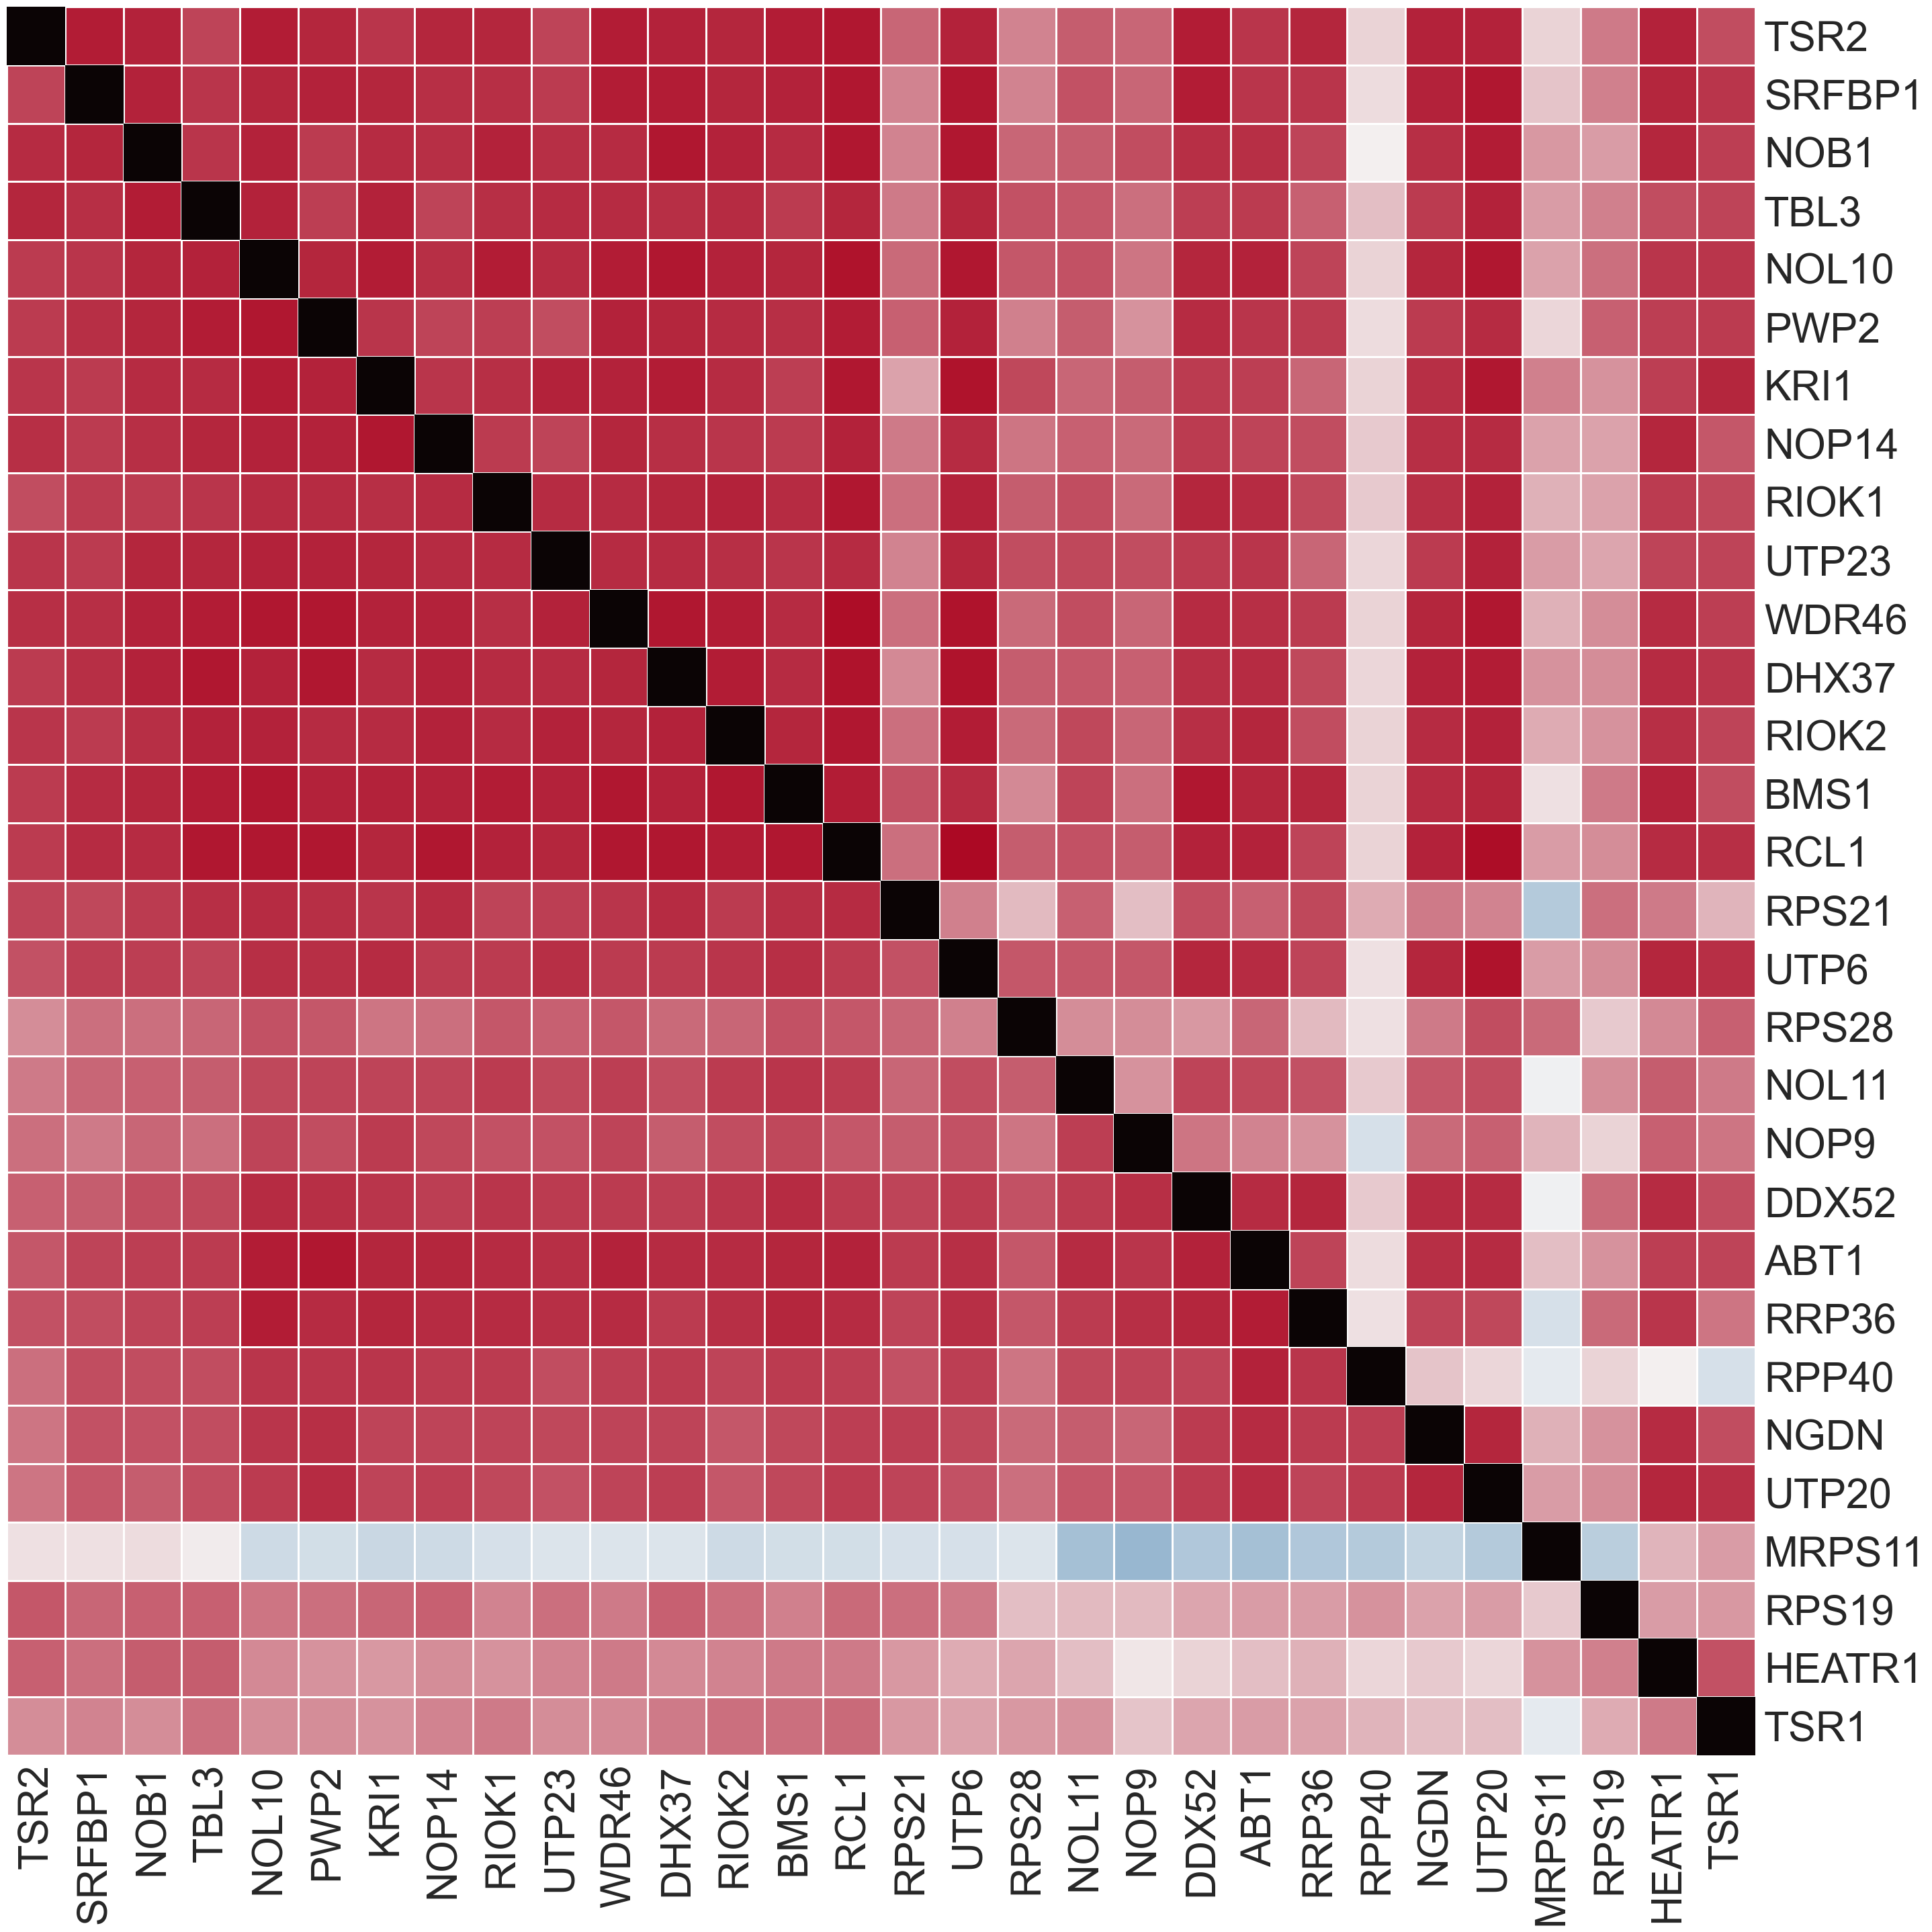

In [6]:
gene_set = 'MATURATION_OF_SSU_RRNA'
genes = gene_set_dict[gene_set]
genes = [i for i in genes if i in hit_list_DMEM]
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first_hits_only',4)

<Figure size 1000x1000 with 0 Axes>

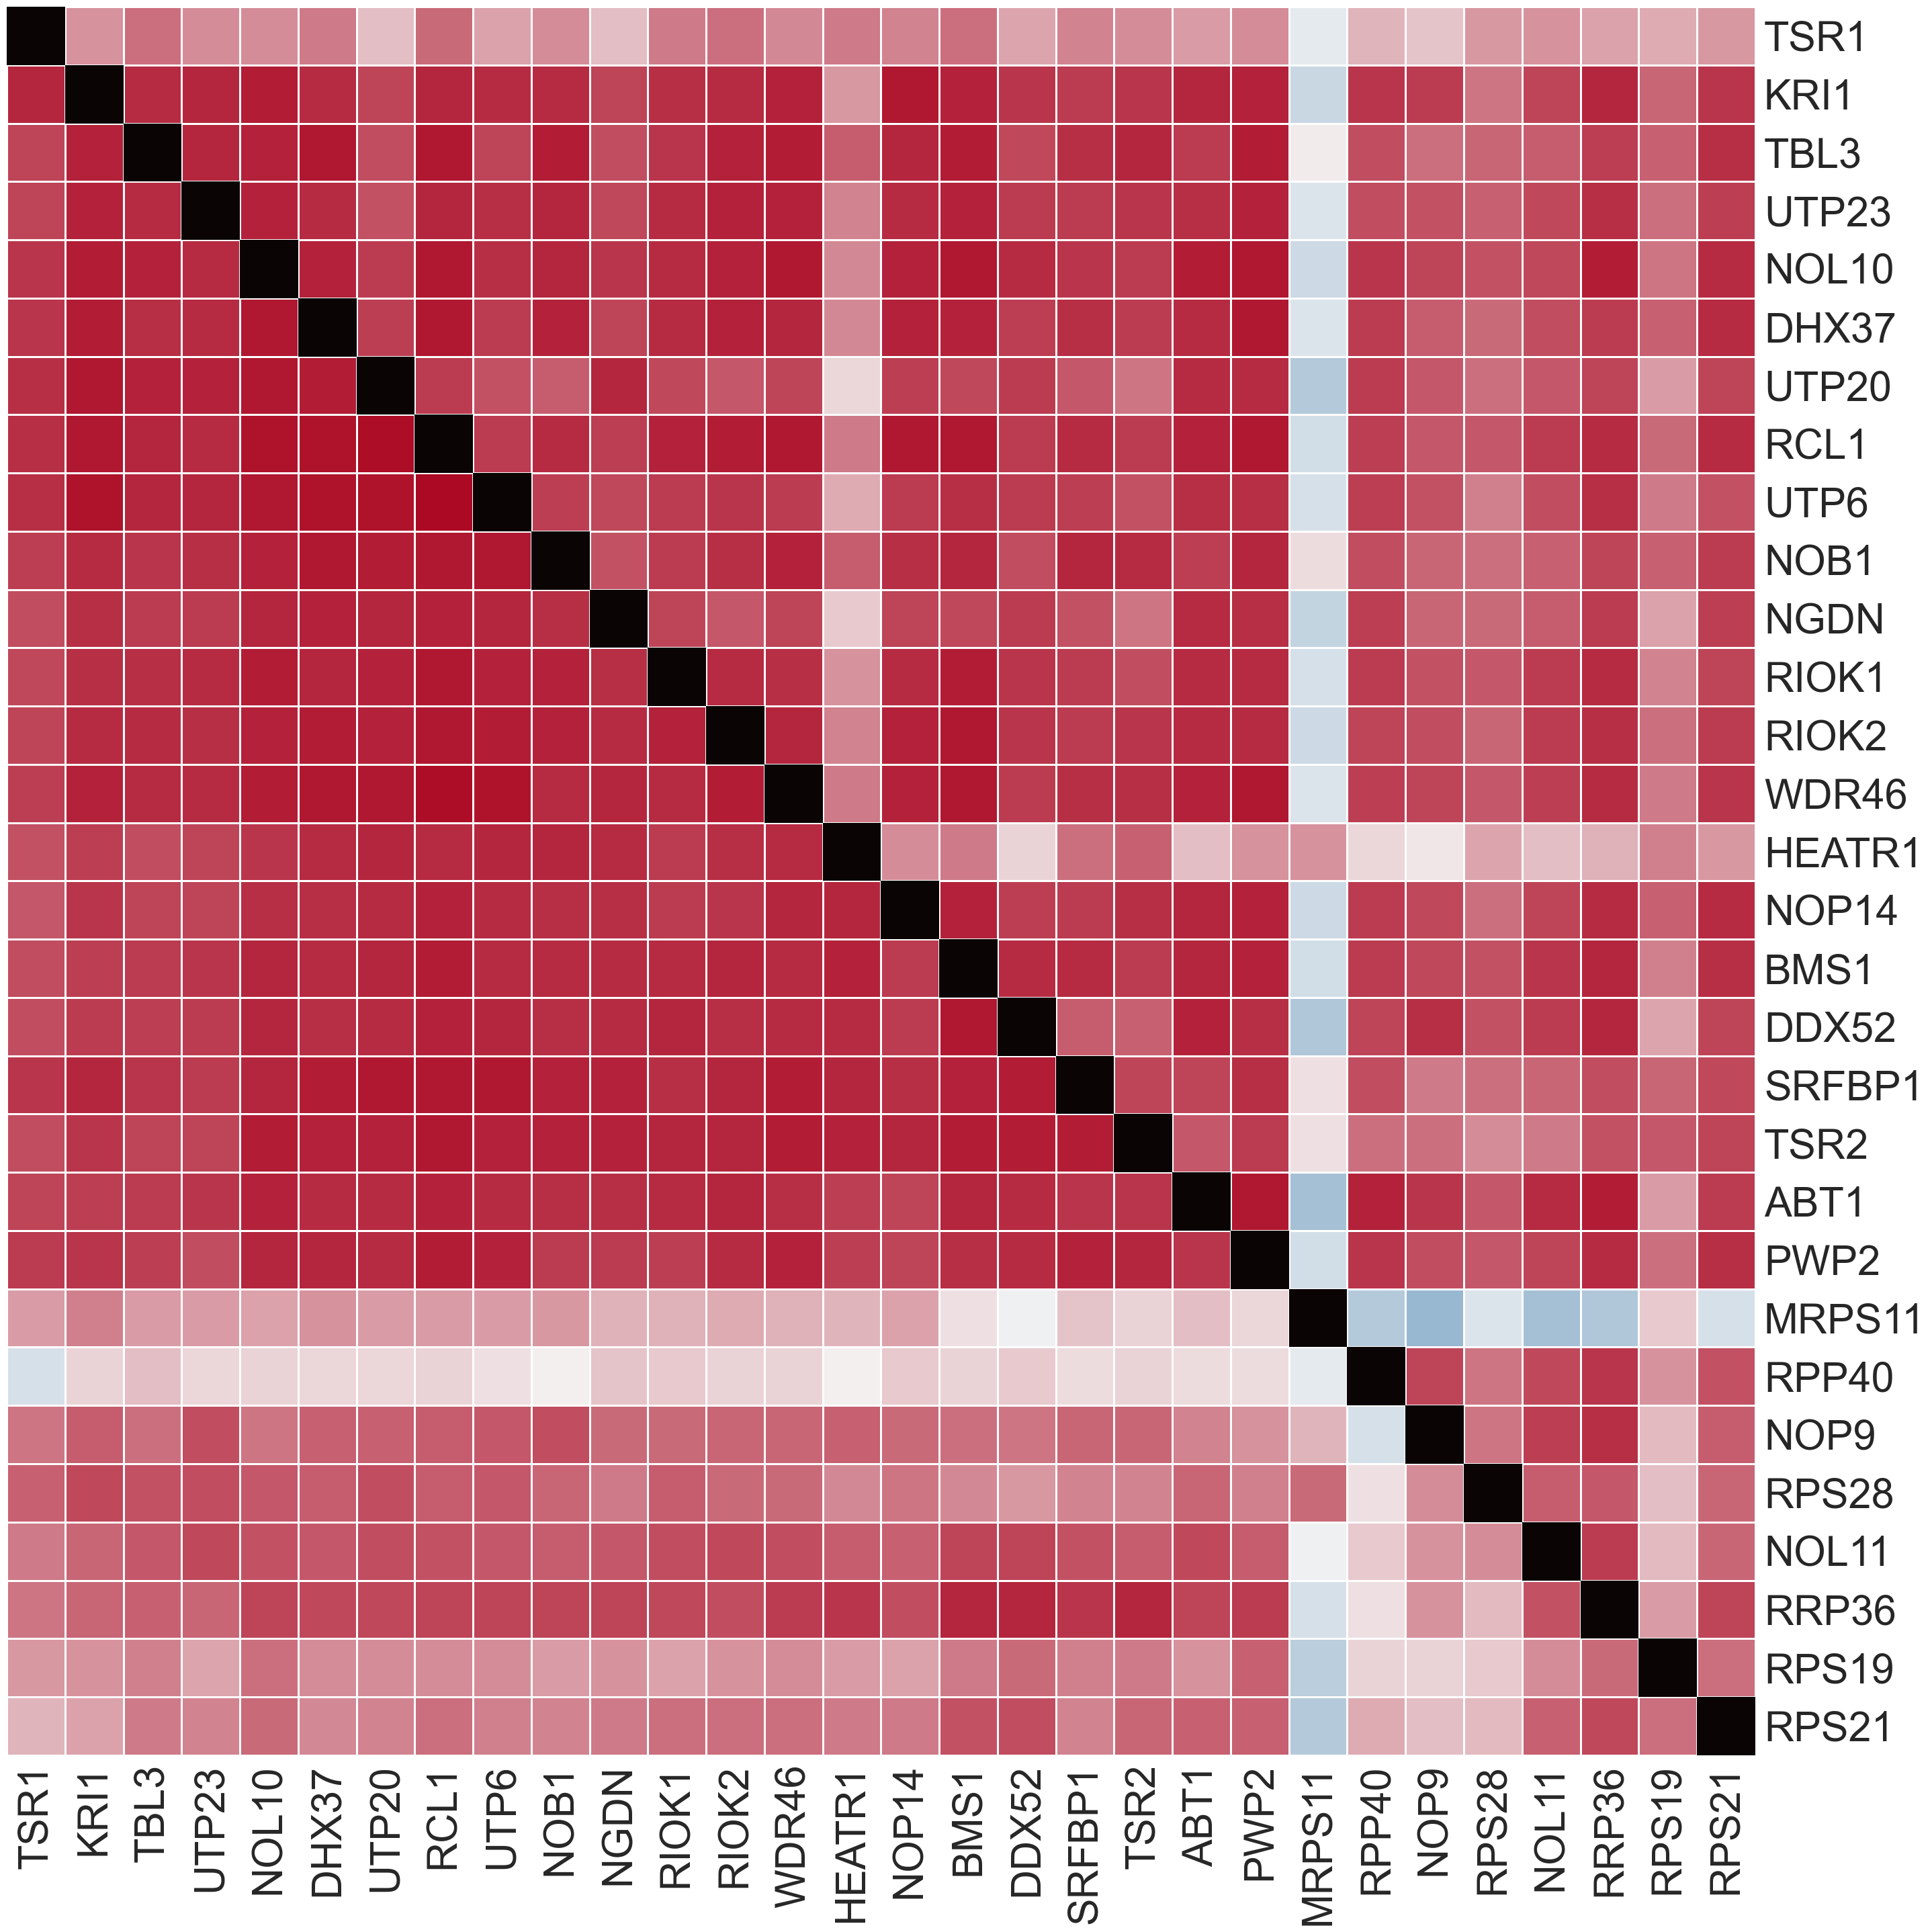

In [7]:
# Clustered based on the HPLM arm first
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first',4,alt_view=True)

<Figure size 1000x1000 with 0 Axes>

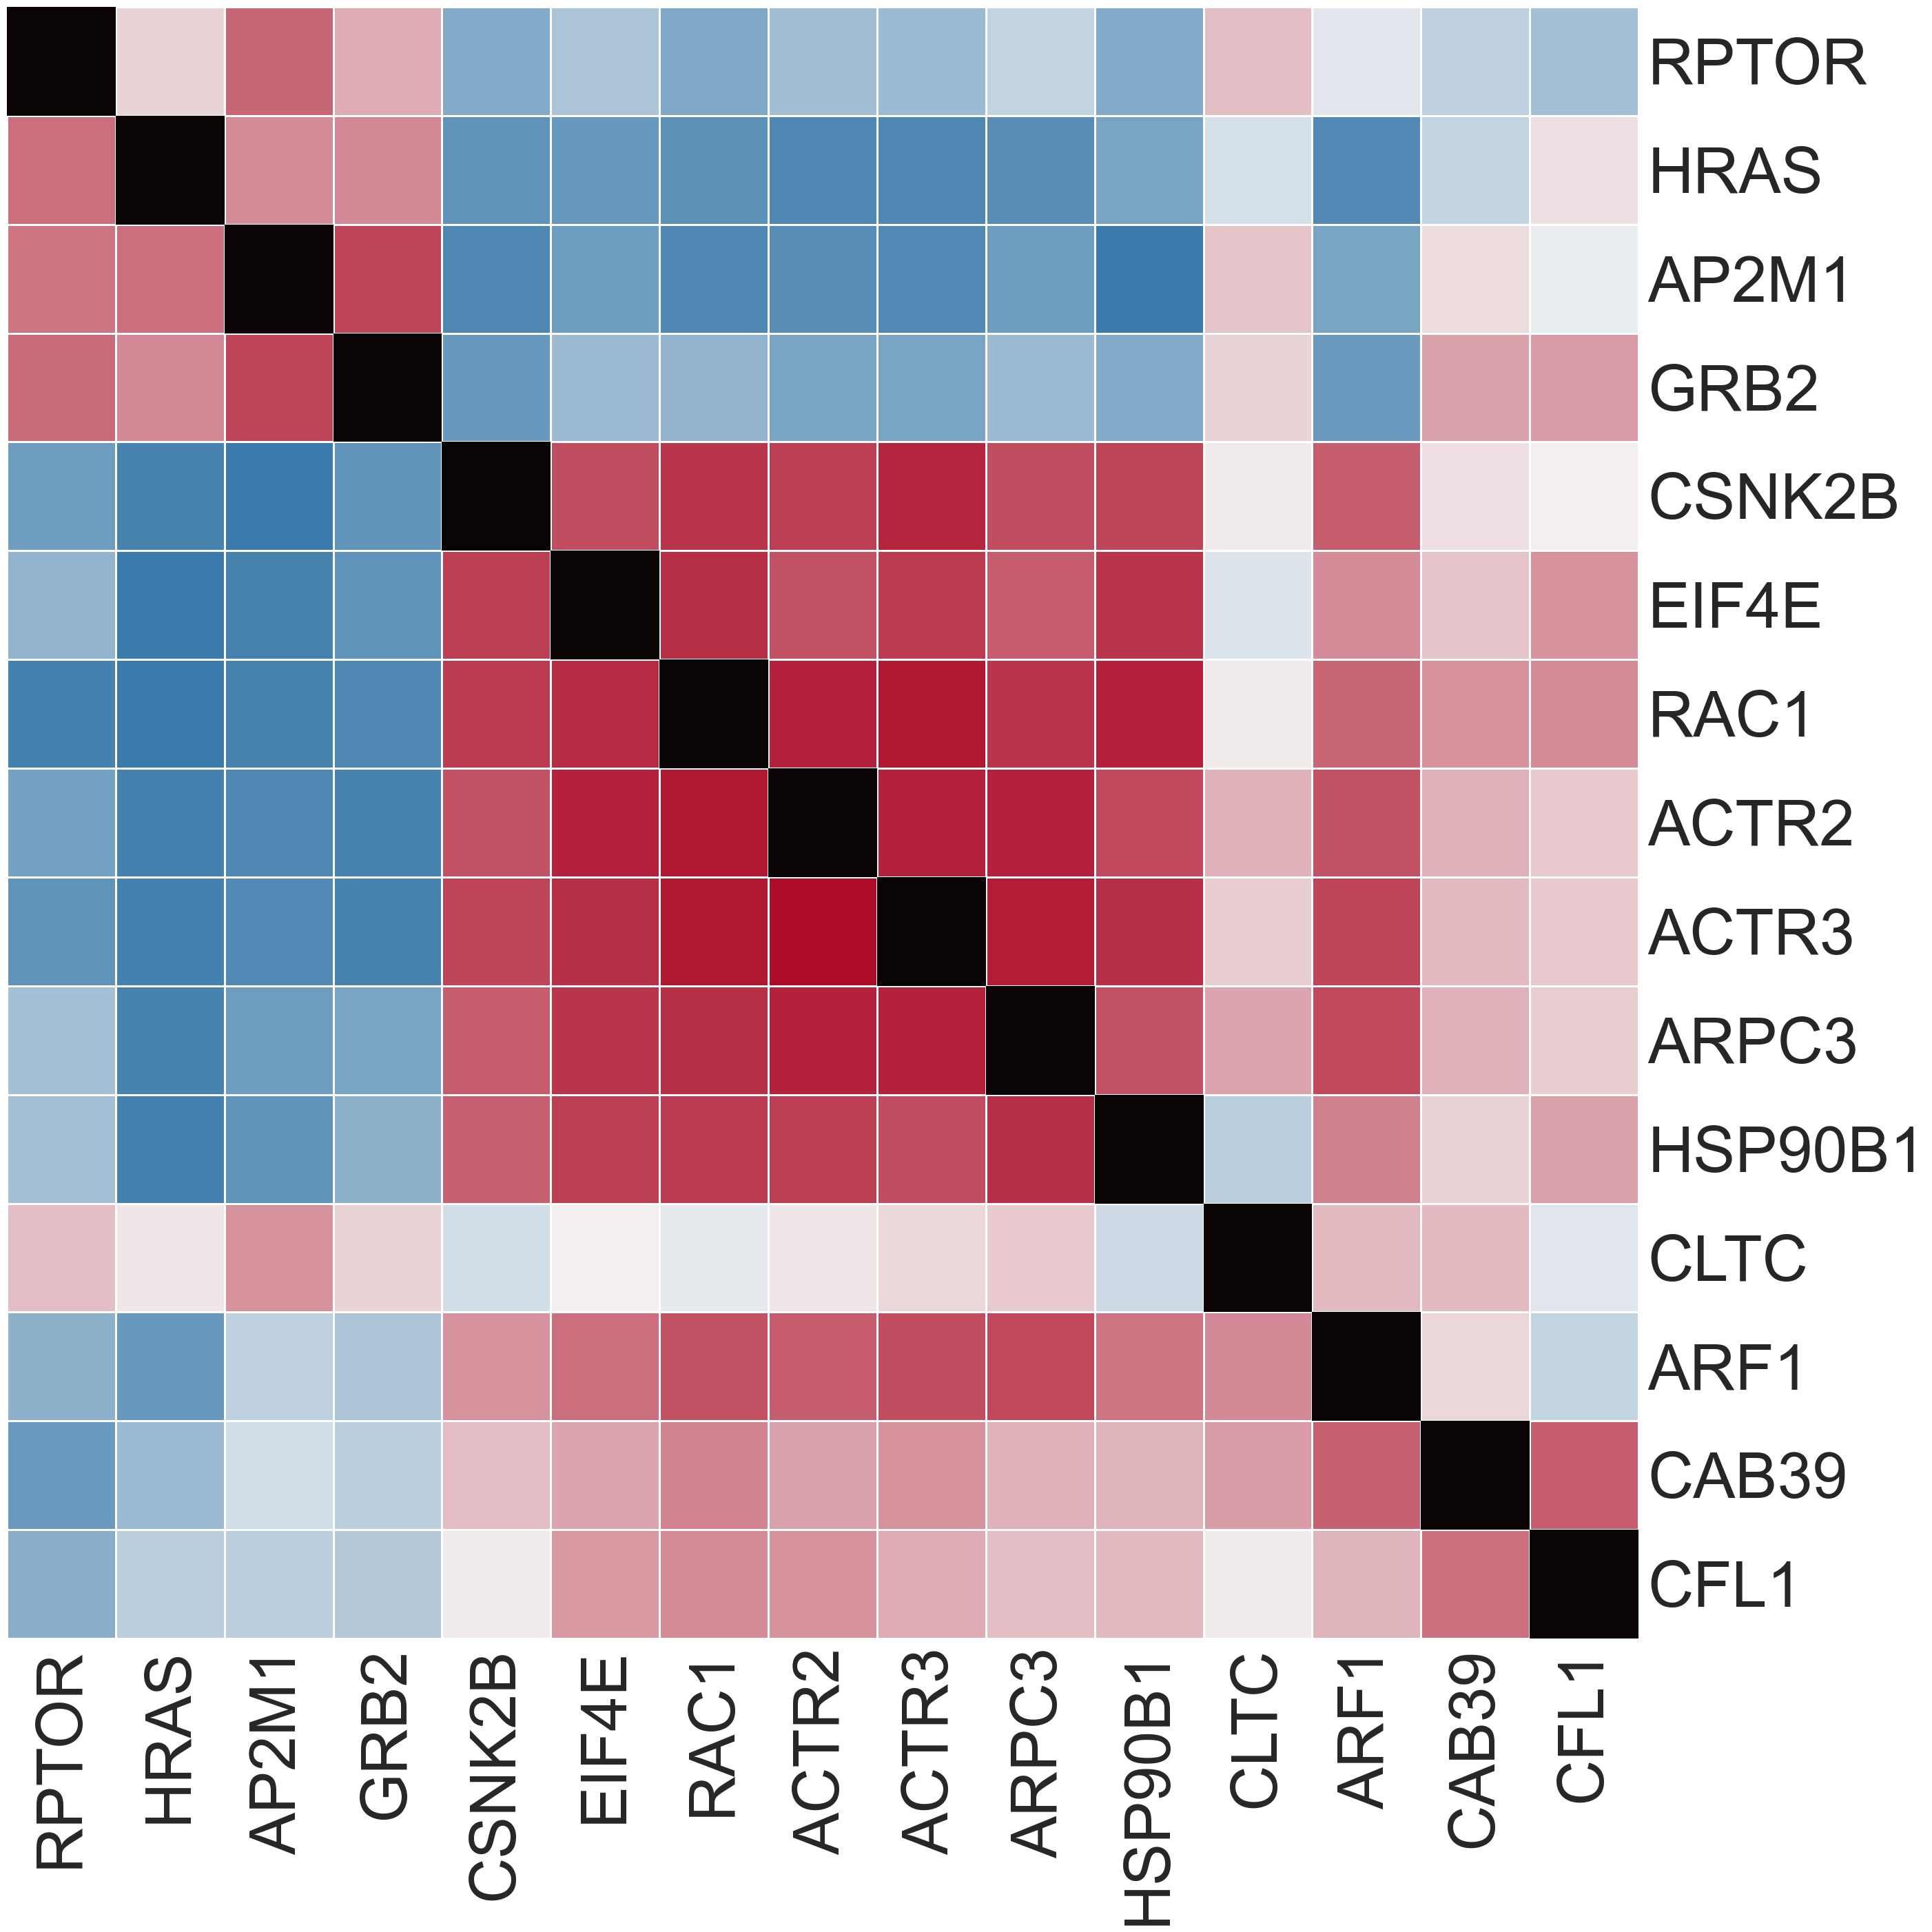

In [8]:
gene_set = 'PI3KAkt_mTOR_Signaling'
genes = gene_set_dict[gene_set]
genes = [i for i in genes if i in hit_list_HPLM]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first_hits_only',6)

<Figure size 1000x1000 with 0 Axes>

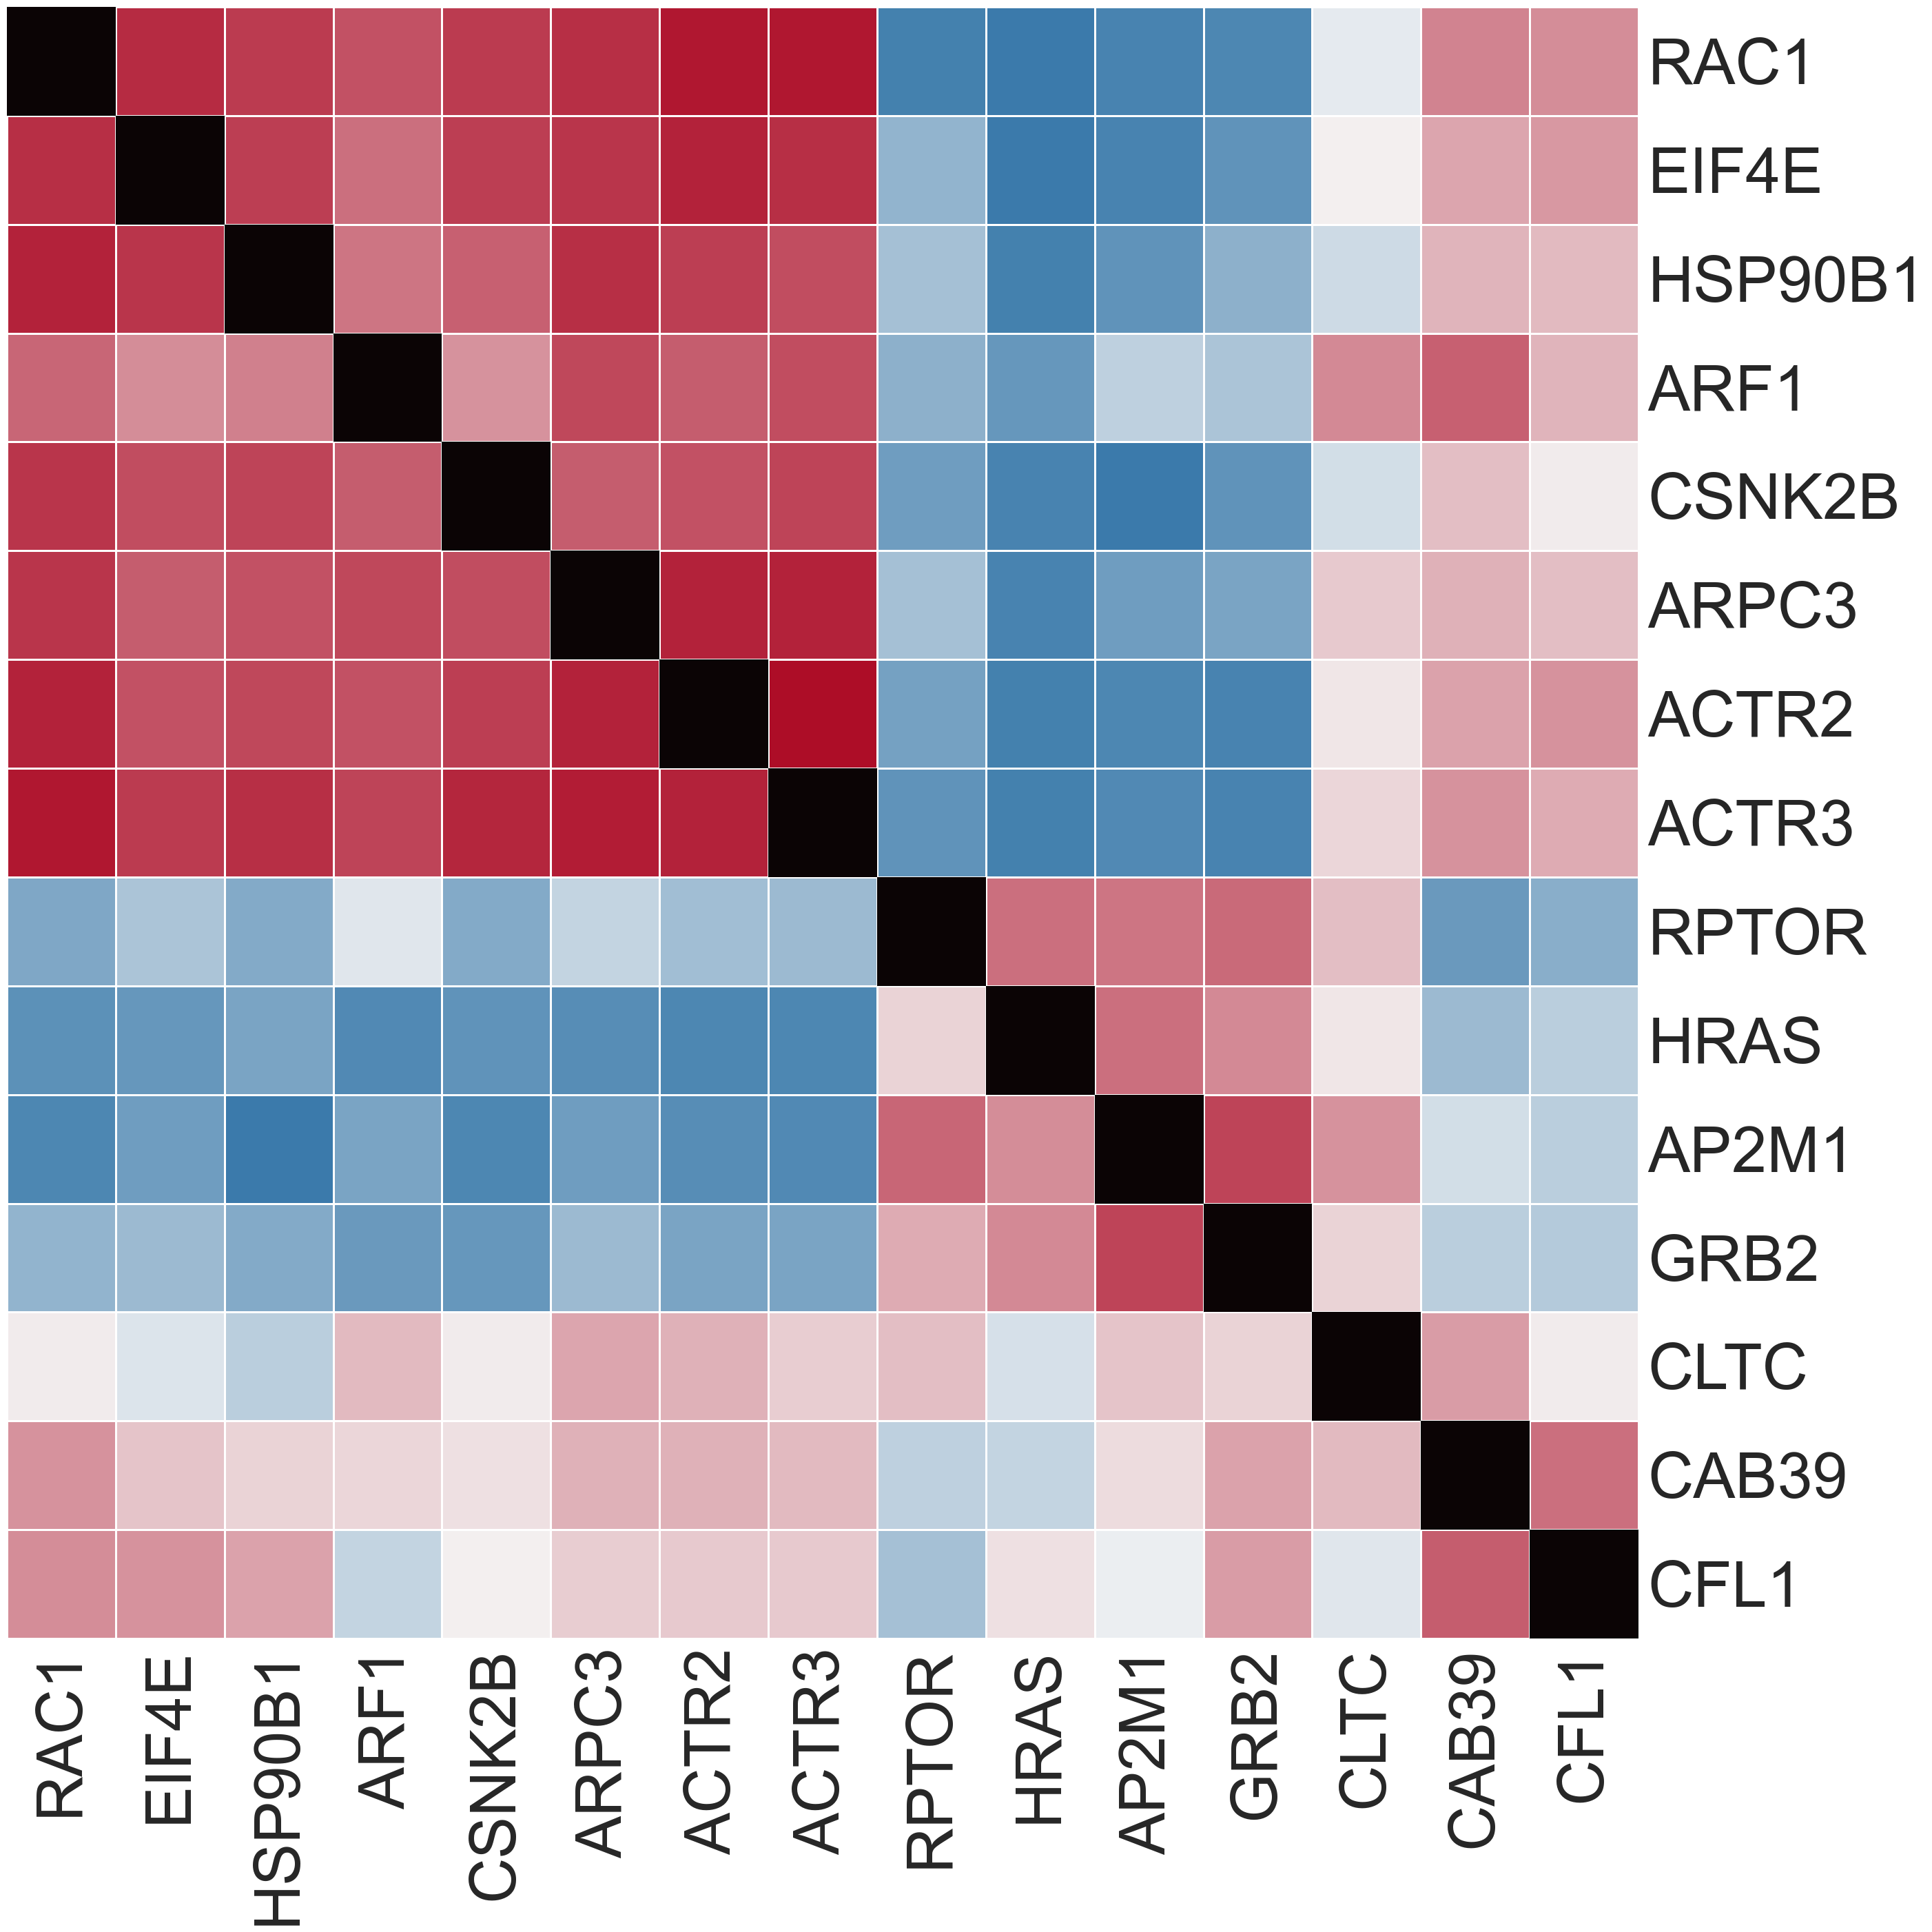

In [9]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',6,alt_view=True)

<Figure size 1000x1000 with 0 Axes>

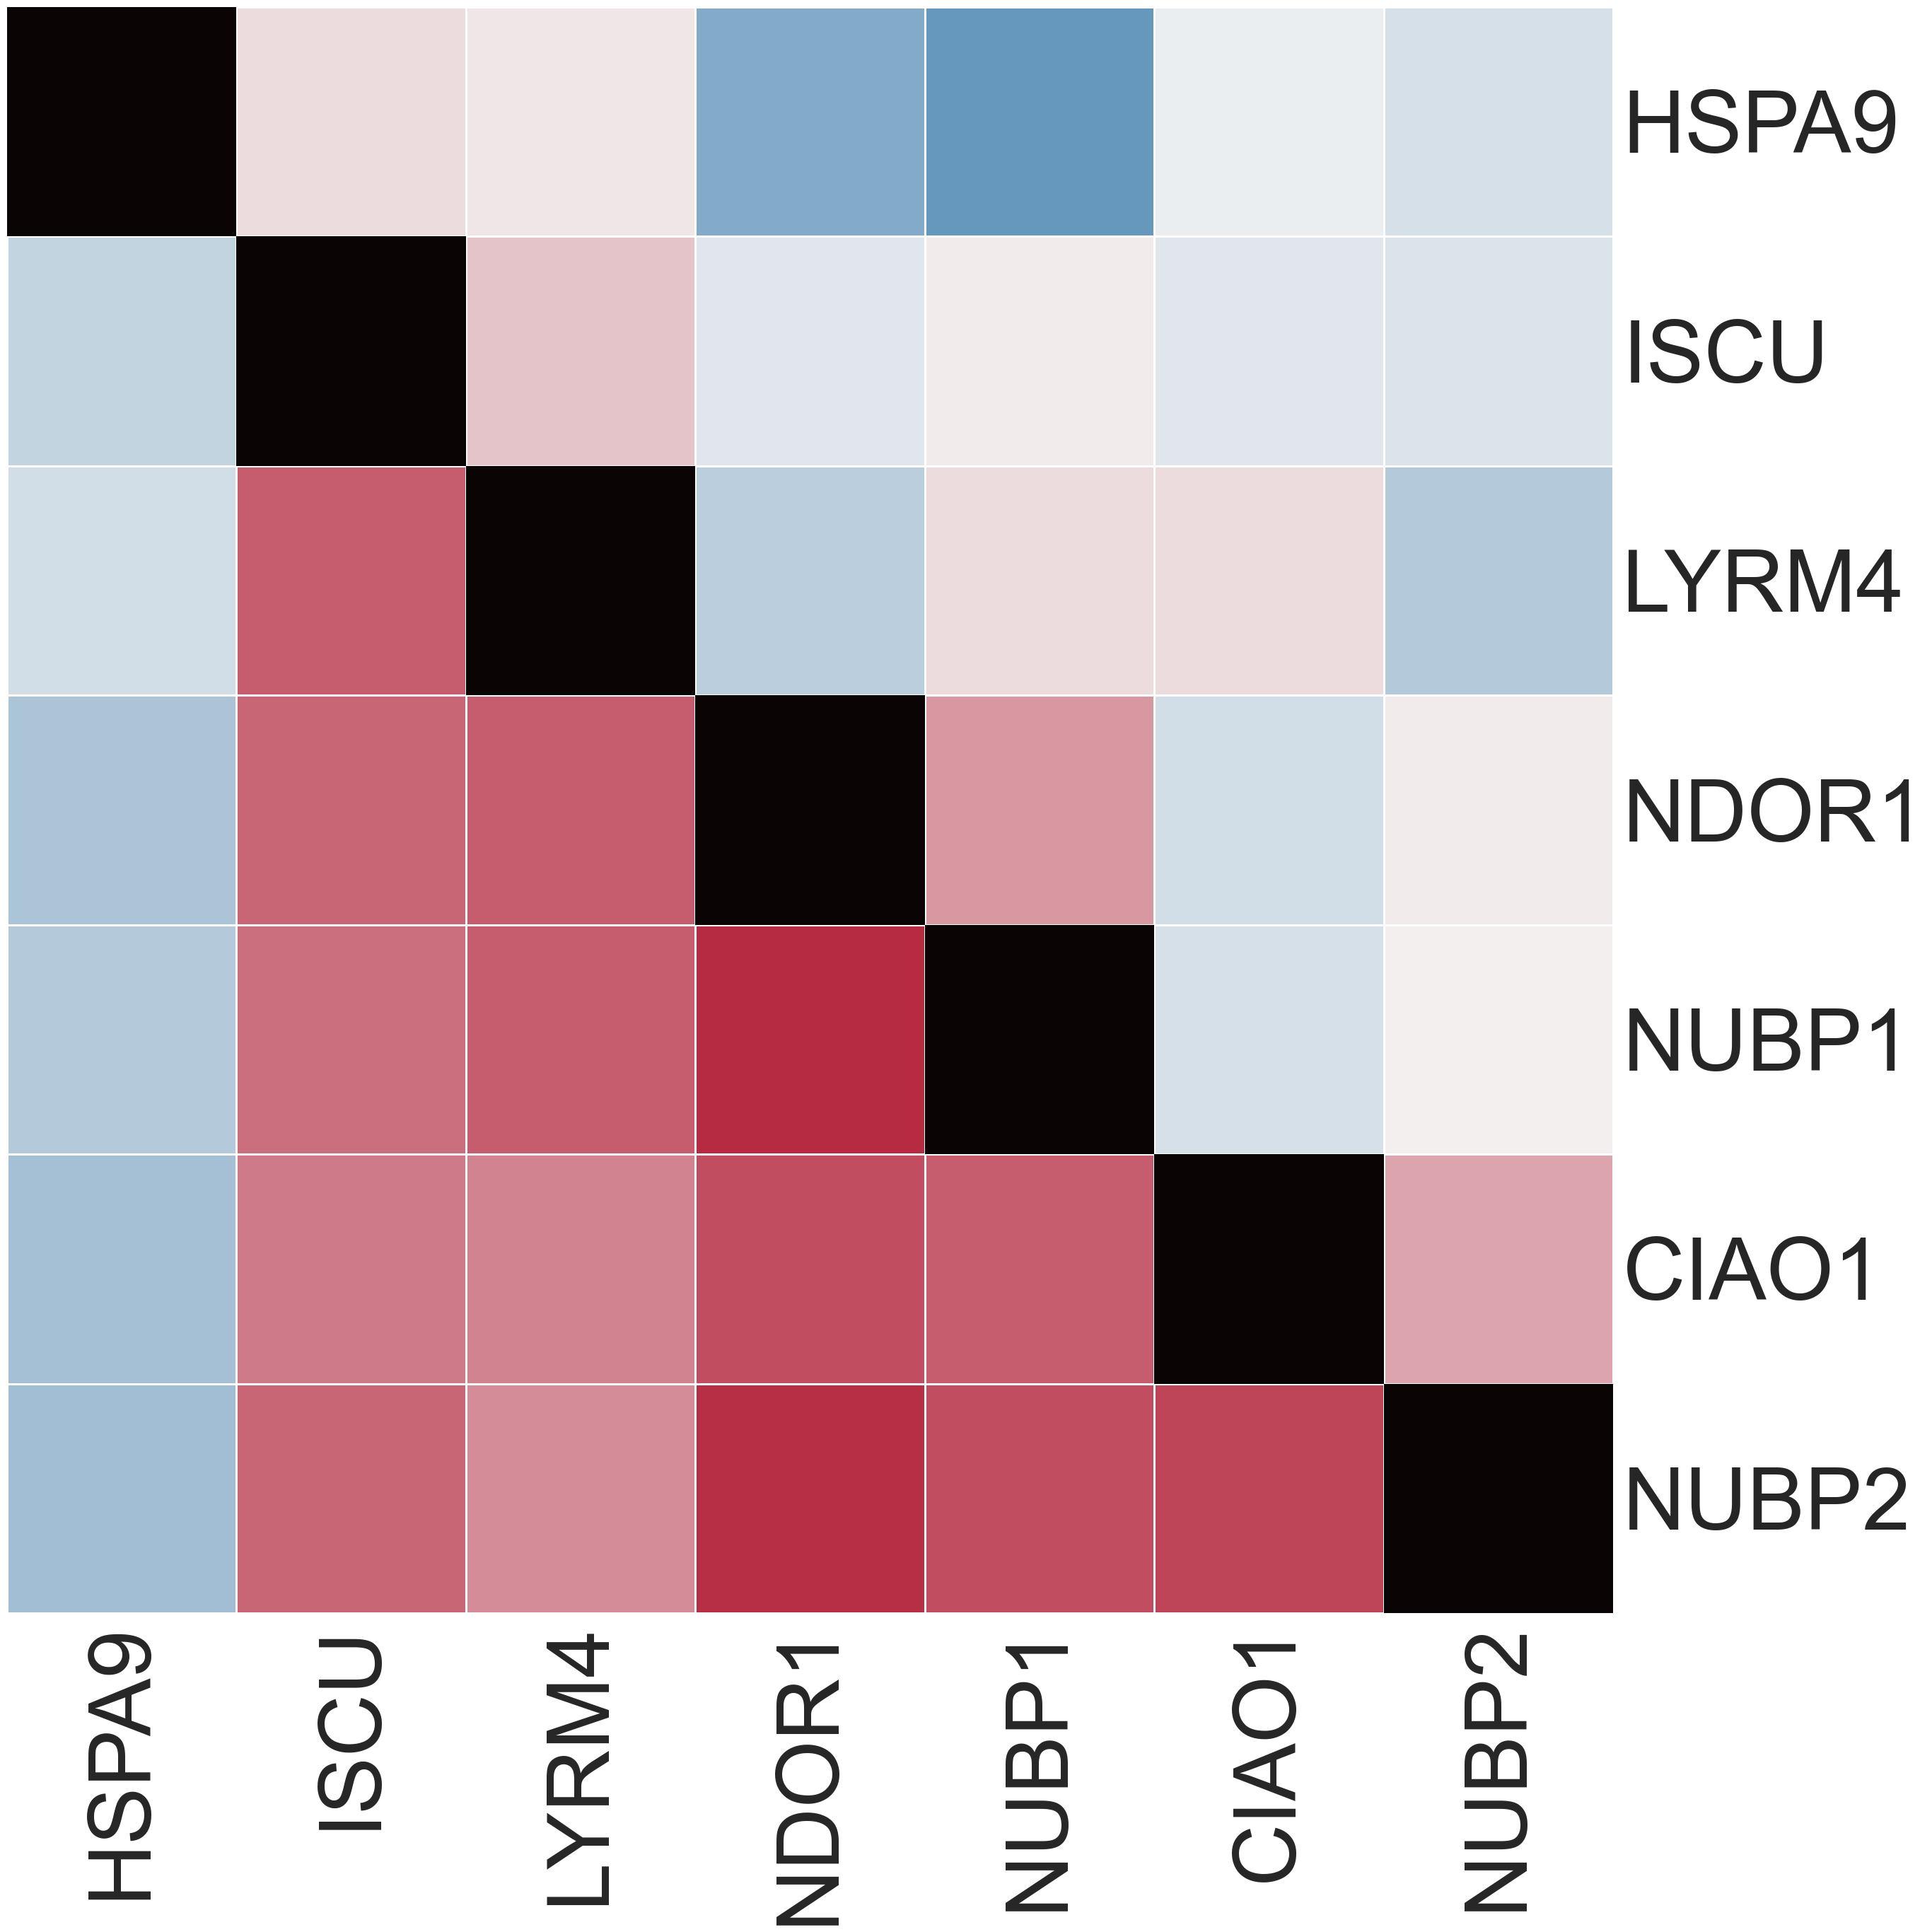

In [10]:
gene_set = 'IRON_SULFUR_CLUSTER_ASSEMBLY'
genes = gene_set_dict[gene_set]
genes = [i for i in genes if i in hit_list_DMEM]
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first_hits_only',8)

<Figure size 1000x1000 with 0 Axes>

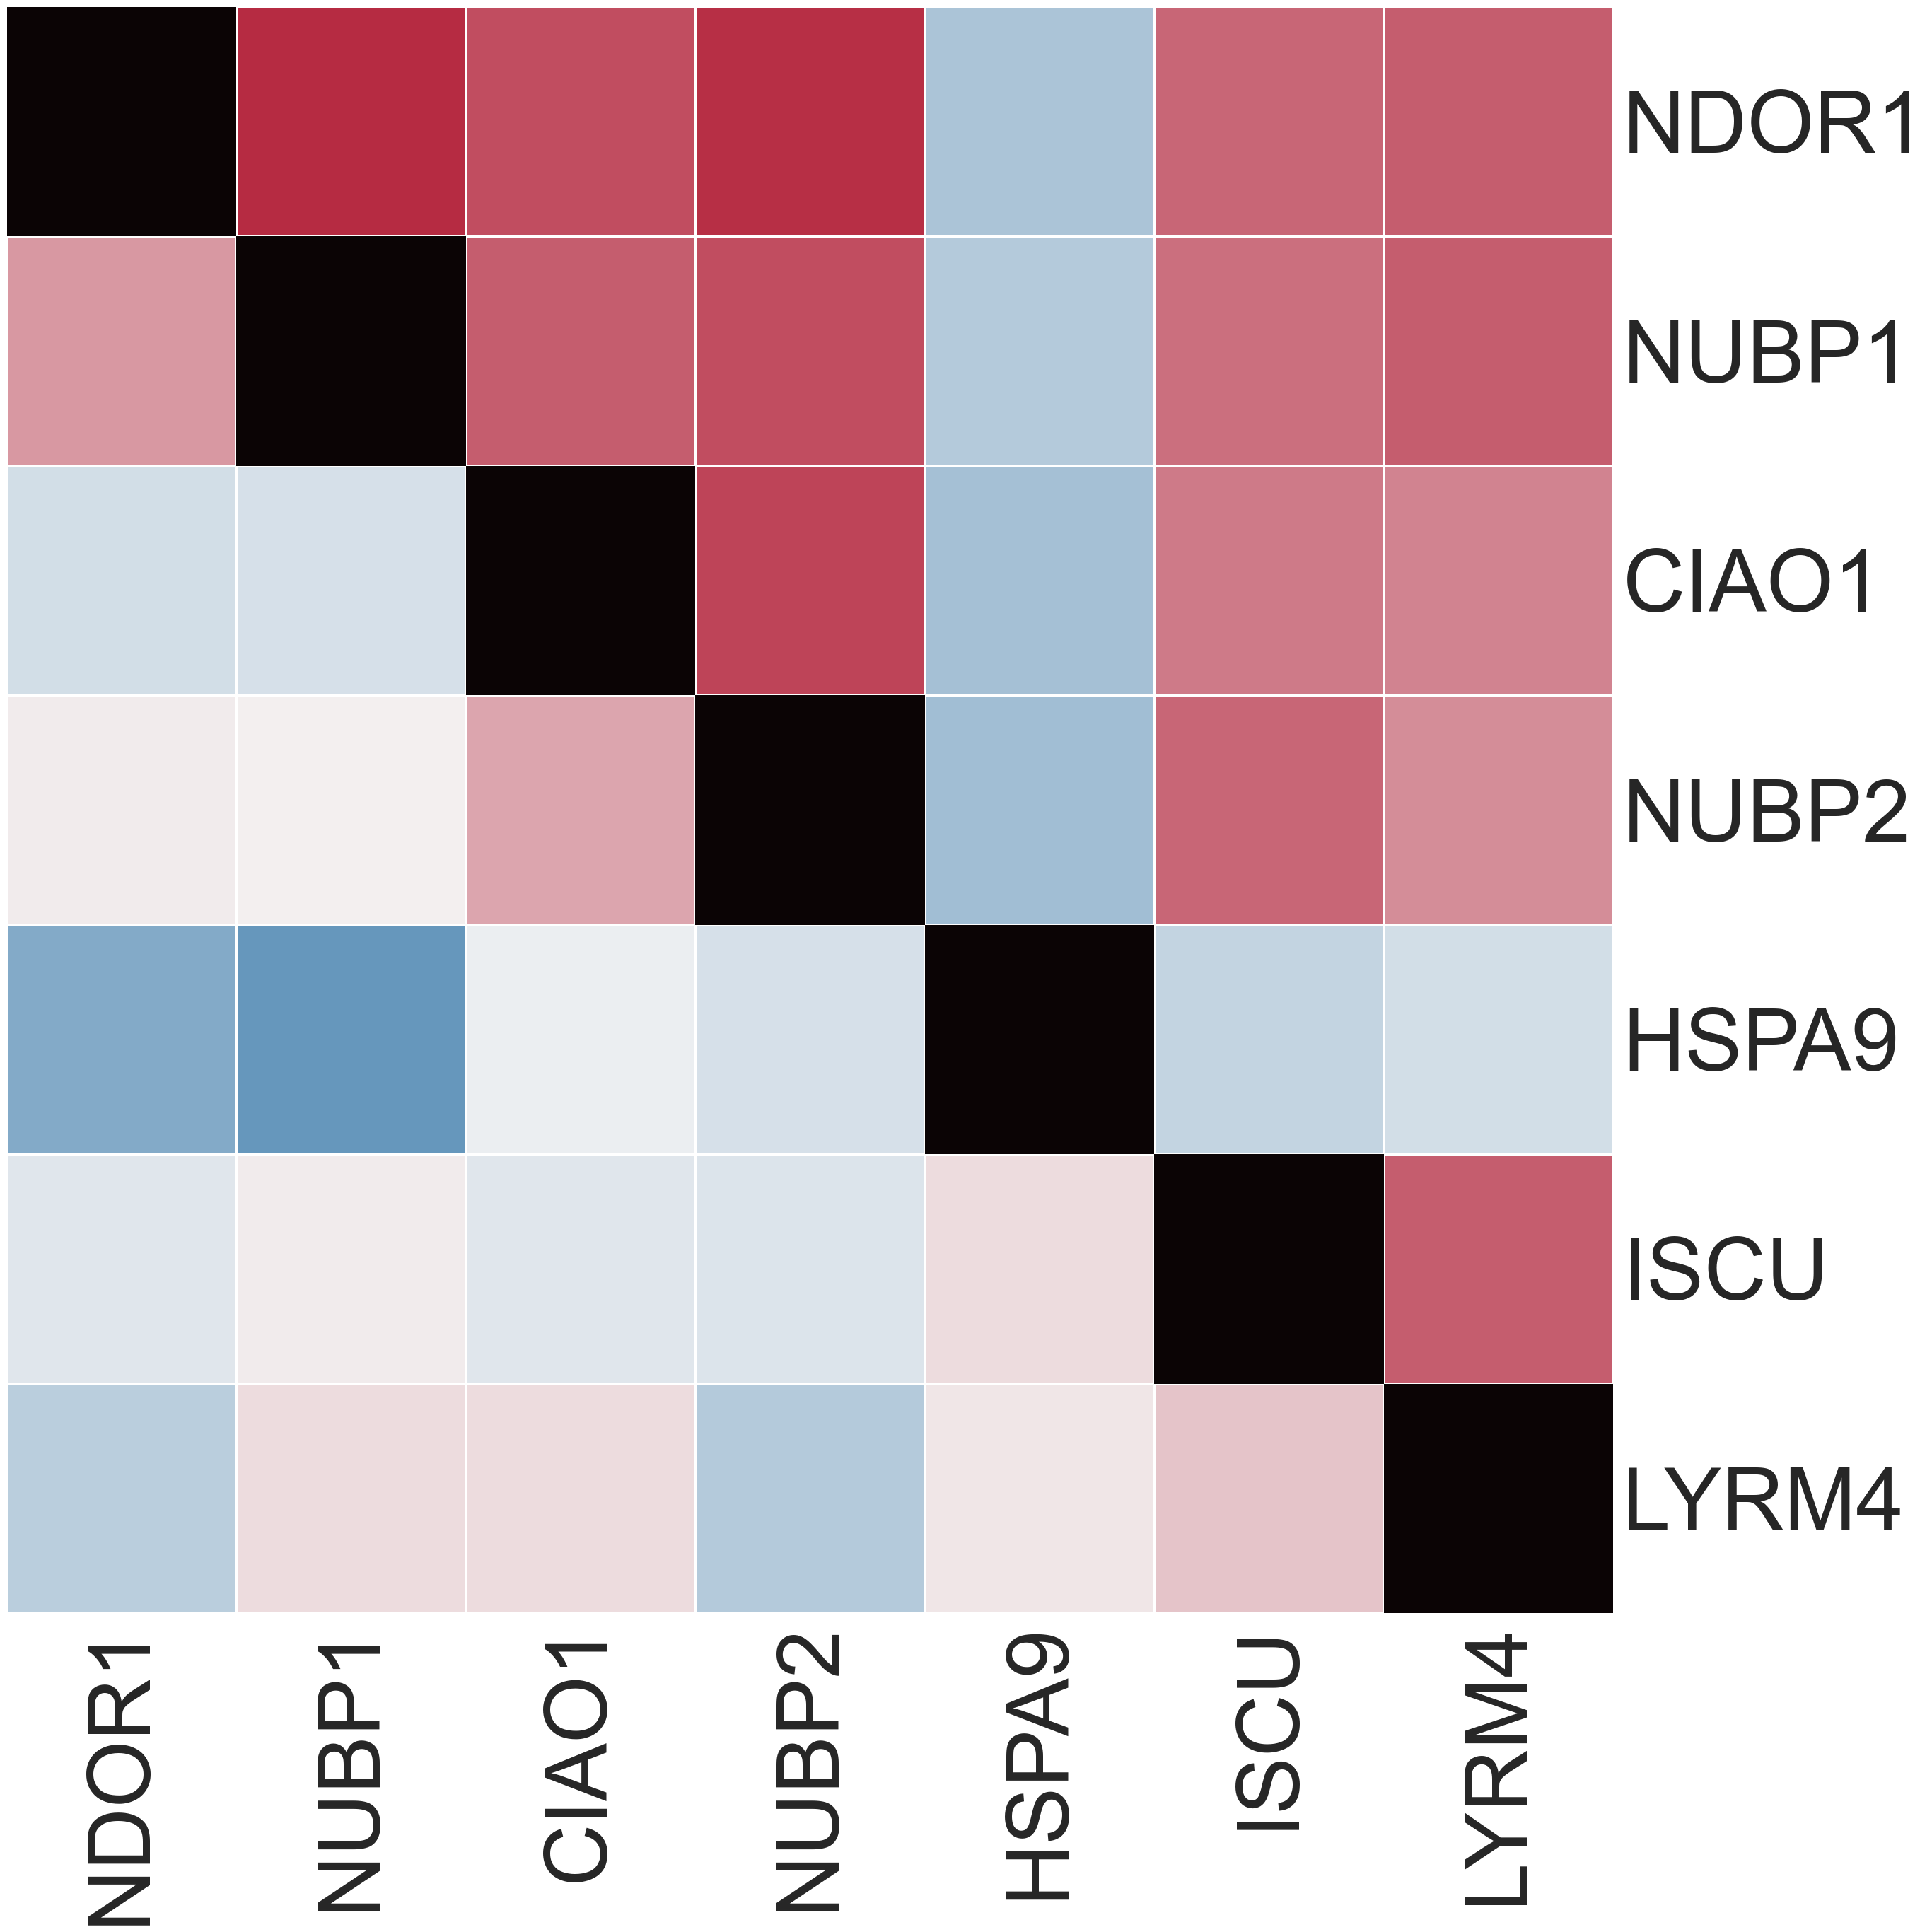

In [11]:
# Clustered based on the HPLM arm first
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first',8,alt_view=True)

<Figure size 1000x1000 with 0 Axes>

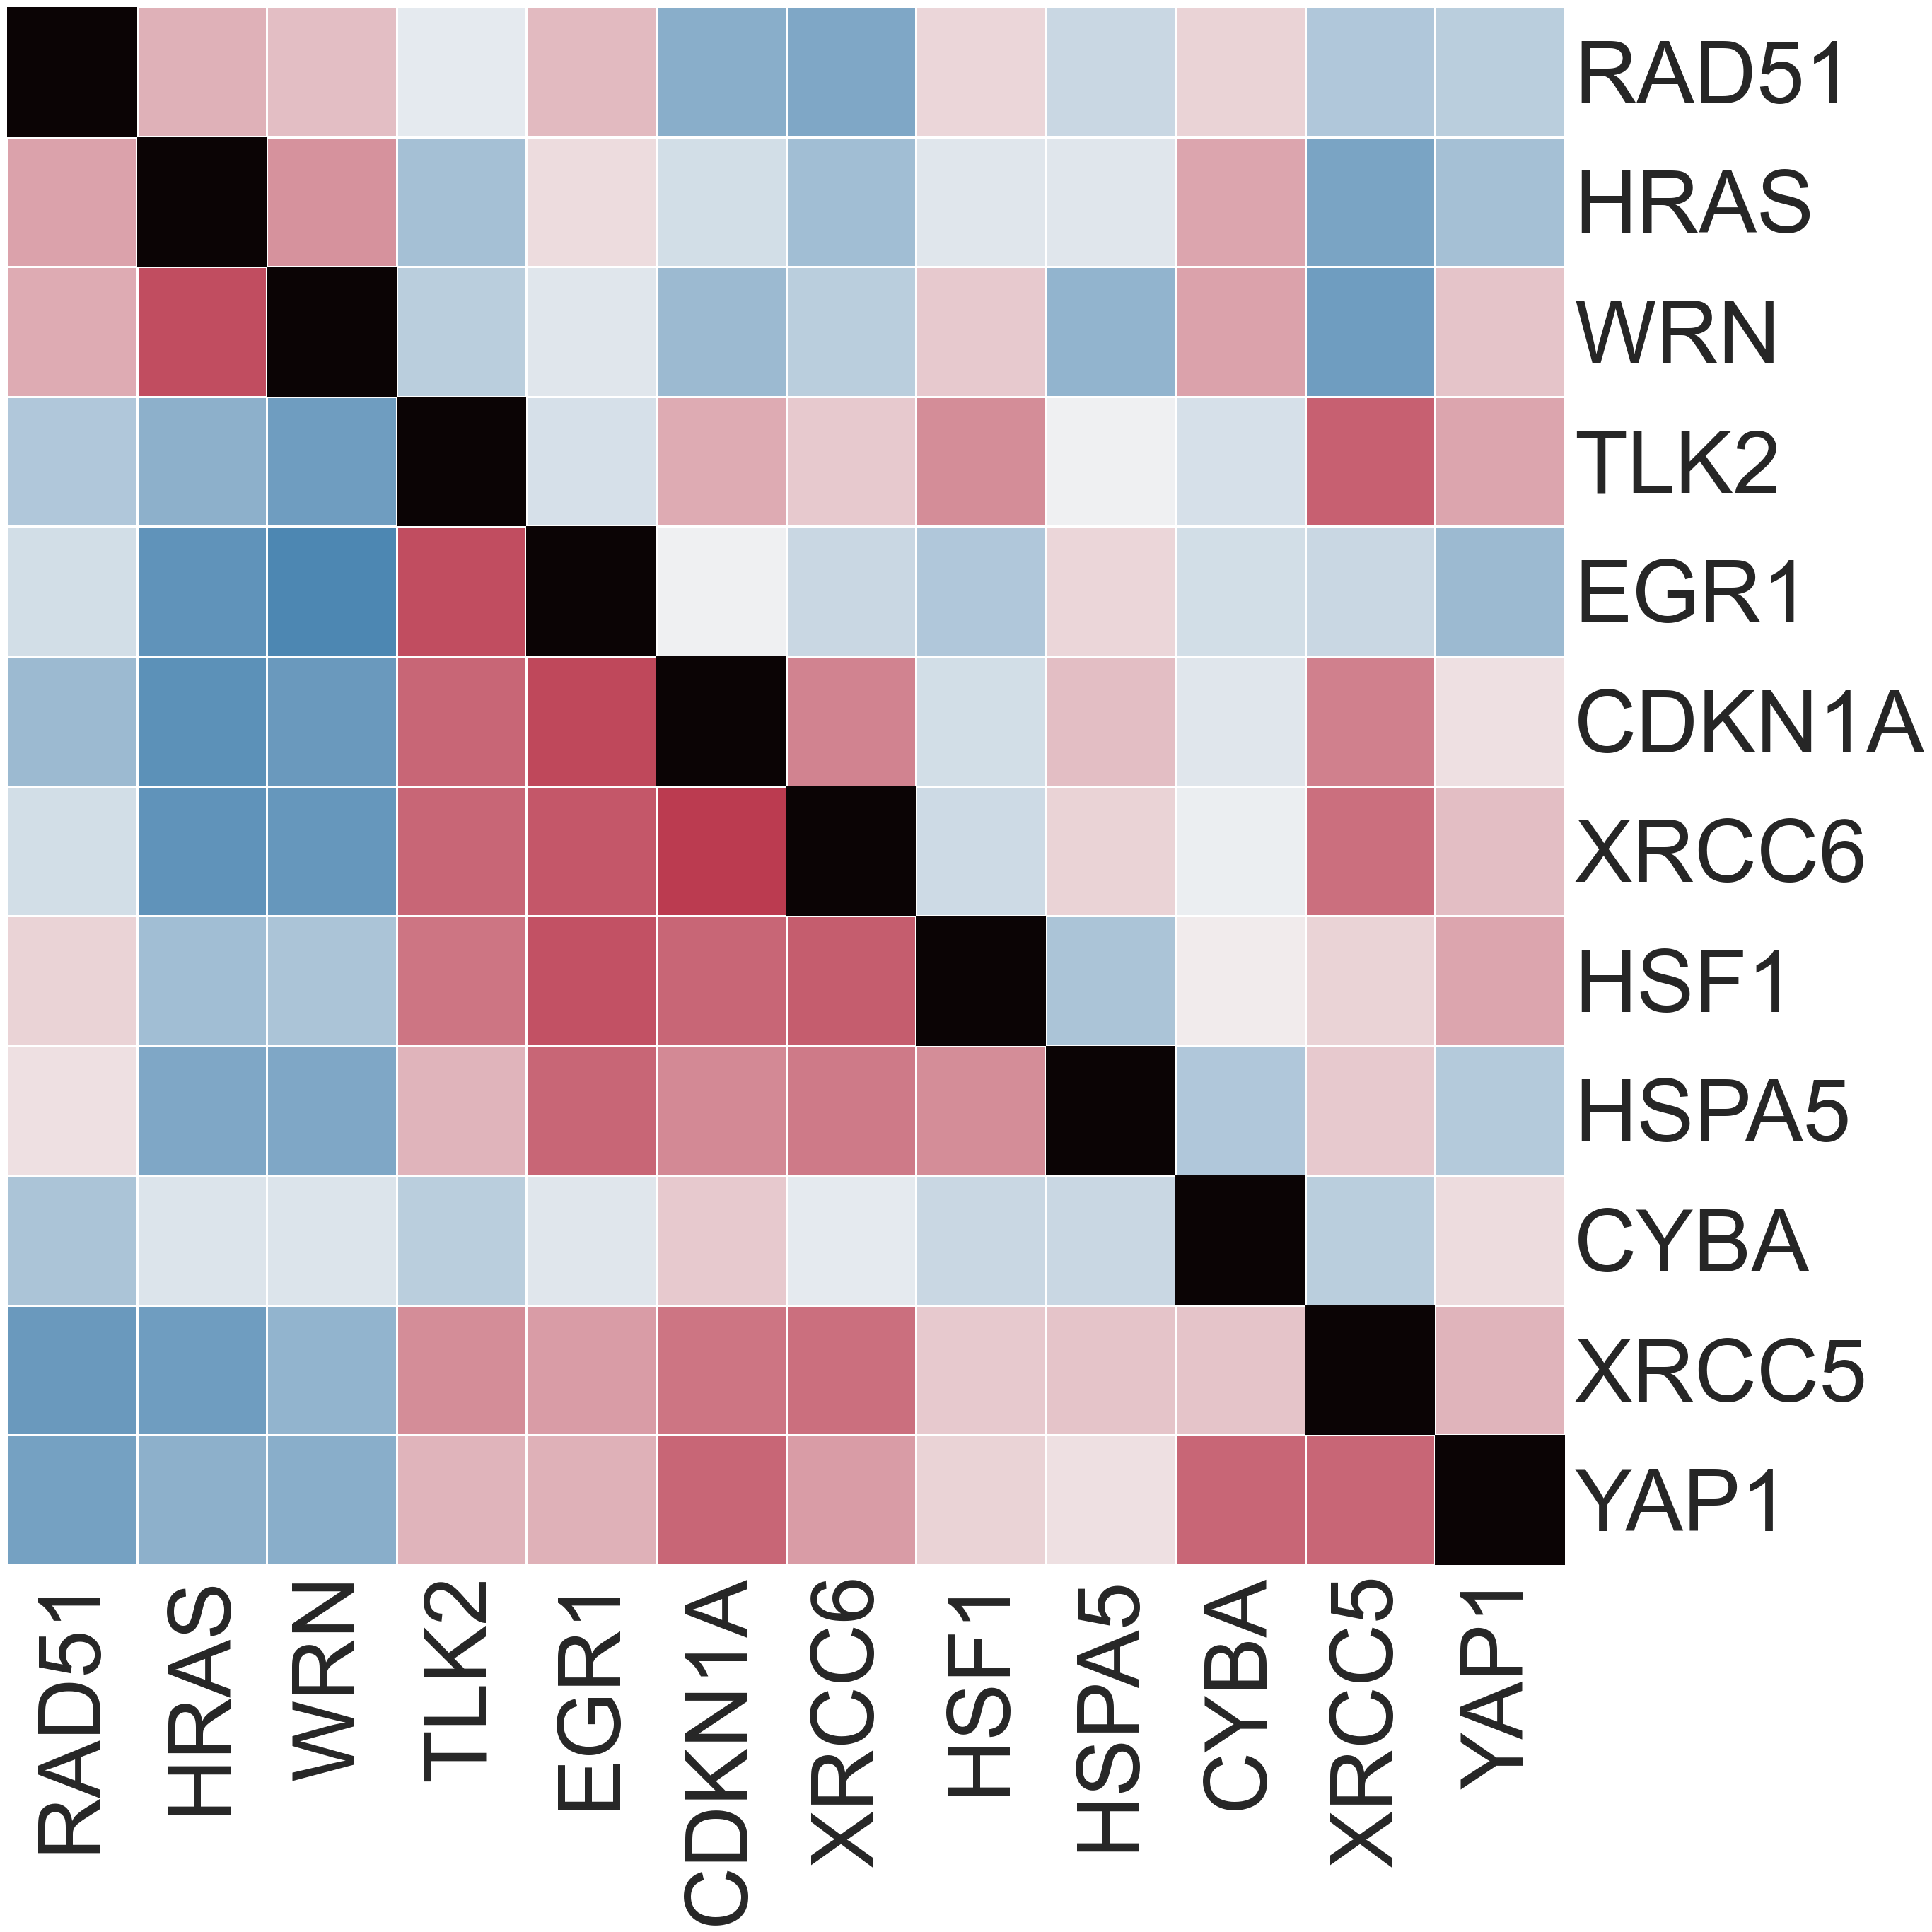

In [12]:
# Clustered based on the HPLM arm first
gene_set = 'CELLULAR_RESPONSE_TO_GAMMA_RADIATION'
genes = gene_set_dict[gene_set]
genes = [i for i in genes if i in hit_list_HPLM]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first_hits_only',8)

<Figure size 1000x1000 with 0 Axes>

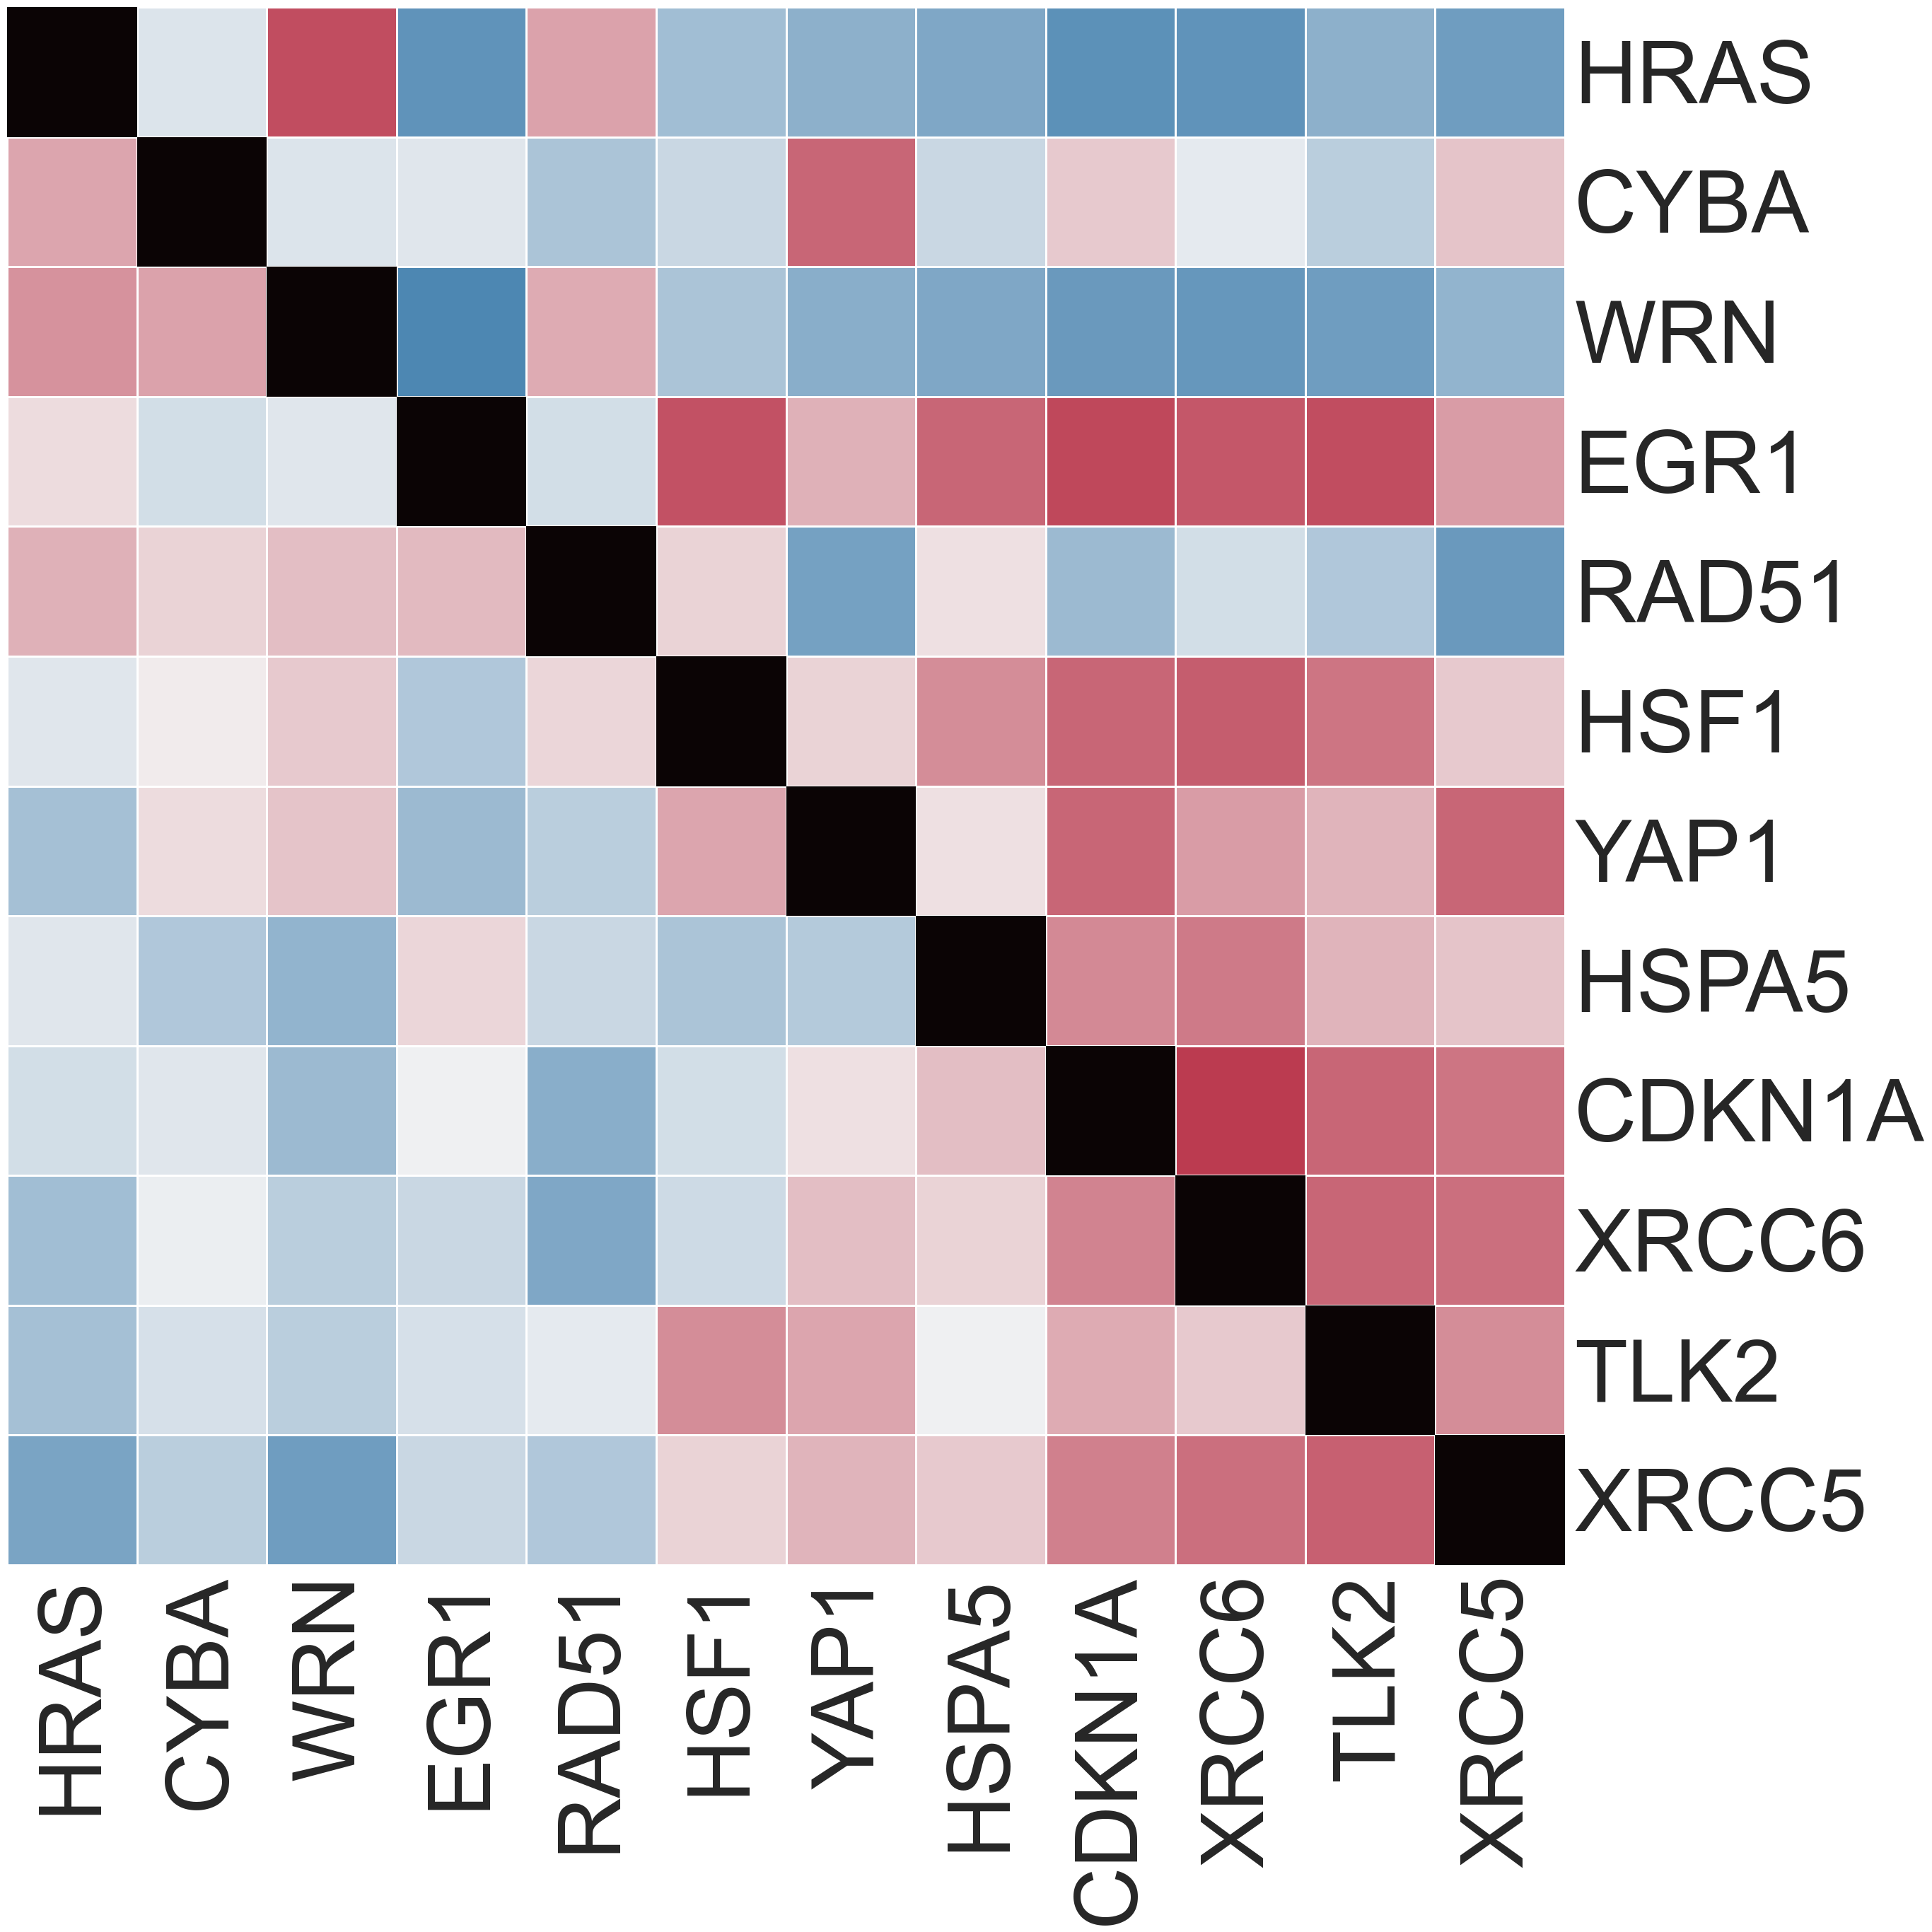

In [13]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',8,alt_view=True)